# 
https://codex.flywire.ai/app/max_clique_challenge

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import csv
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import math
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from scipy.sparse import csr_matrix, issparse

In [2]:
def read_local_csv(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        # The data contains integer IDs, so we convert them during reading
        rows = [[int(node) for node in row] for row in reader]
        print(f"Loaded {len(rows)} rows from {path}")
        return rows

calc_density = lambda e, n: sum(1 for a, b in e if a in n and b in n) / (len(n)*(len(n)-1)/2)
edges = read_local_csv(r"edges.csv")

# adopted from: https://colab.research.google.com/drive/19LyhHJ3cEL6B5wAzVPapWRKVRdXlg-kr?usp=sharing
def verify(solution_path = "max_clique_submission_benchmark_1_1.csv"):
    read_solution = lambda: read_local_csv(solution_path)
    calc_score = lambda kis: sum(k / 2**i for i, k in enumerate(kis))

    def eval(rows, edges, d=12):
        kis = [0]*d
        for r in rows:
            k, δ = len(r), calc_density(edges, set(r))
            for i in range(d):
                if δ >= 1 / 2**i: kis[i] = max(kis[i], k)
            print(f"- found subgraph of size {k} with density {δ}; {kis=} {calc_score(kis)=}")
        return calc_score(kis)

    print(f"Final score: {eval(read_solution(), edges)}")

# verify()

Loaded 2511789 rows from edges.csv


In [6]:
verify("final.csv")

Loaded 12 rows from final.csv
- found subgraph of size 40 with density 1.0; kis=[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40] calc_score(kis)=79.98046875
- found subgraph of size 175 with density 0.5022660098522167; kis=[40, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175] calc_score(kis)=214.91455078125
- found subgraph of size 369 with density 0.2505891363261459; kis=[40, 175, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369] calc_score(kis)=311.81982421875
- found subgraph of size 723 with density 0.1250100573556626; kis=[40, 175, 369, 723, 723, 723, 723, 723, 723, 723, 723, 723] calc_score(kis)=400.14697265625
- found subgraph of size 1541 with density 0.06250031603698054; kis=[40, 175, 369, 723, 1541, 1541, 1541, 1541, 1541, 1541, 1541, 1541] calc_score(kis)=501.99755859375
- found subgraph of size 3109 with density 0.031250038808739354; kis=[40, 175, 369, 723, 1541, 3109, 3109, 3109, 3109, 3109, 3109, 3109] calc_score(kis)=599.23193359375
- found subgraph of size 6207 wi

In [ ]:
densities = [1/2**d for d in range(12)]

def save_output_csv(quasi_cliques: list[list[int]], output_path: str="res.csv", convert_idx = True):
    """
    Converts the quasi-clique node indices to their original IDs and saves them to a CSV file:
    Each row = comma-separated neuron IDs (one subgraph per row)
    """
    with open(output_path, 'w', newline='') as f:
        f.write("") # Create an empty file, truncating if it exists
    for quasi_clique in quasi_cliques:
        if convert_idx:
            original_node_ids = [all_nodes[i] for i in quasi_clique]
        else:
            original_node_ids = quasi_clique
        with open(output_path, "a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(original_node_ids)


def merge_best_csv(file_names: list[str]):
    max_sol = {}
    for file_name in file_names:
        sol_ = read_local_csv(file_name)

        for d_sol, d in zip(sol_, densities):
            if d not in max_sol or len(d_sol) > len(max_sol[d]):
                max_sol[d] = d_sol
    return max_sol

In [ ]:
my_sol = read_local_csv("final.csv")
my_sol_lens = {}
my_sol_data = {}
for my_sol_, d in zip(my_sol, densities):
    my_sol_lens[d] = len(my_sol_)
    my_sol_data[d] = my_sol_
best_solution = list(my_sol_lens.values())
my_sol_lens

### Data

In [4]:
def get_graph(edges: list, all_nodes: list[int]) -> nx.Graph:
    print(f"Edges: {len(edges)}")
    print(f"Nodes: {len(all_nodes)}")
    node_to_idx = {node: i for i, node in enumerate(all_nodes)}

    row_indices = []
    col_indices = []
    for u, v in edges:
        u_idx = node_to_idx[u]
        v_idx = node_to_idx[v]
        row_indices.append(u_idx)
        col_indices.append(v_idx)
        # Add the symmetric edge for an undirected graph
        row_indices.append(v_idx)
        col_indices.append(u_idx)

    data = np.ones(len(row_indices), dtype=np.uint8)
    n_nodes = len(all_nodes)
    adj_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(n_nodes, n_nodes))

    print(f"Number of non-zero elements (2*E): {adj_matrix.nnz}")
    print(f"Precentage of non-zero elements: {adj_matrix.nnz / (n_nodes * n_nodes) * 100:.2f}%")
    print(f"Density:", calc_density(edges, set(all_nodes)))

    return nx.from_scipy_sparse_array(adj_matrix, create_using=nx.Graph), adj_matrix


def csr_to_adjdict(mat: csr_matrix):
    """csr → {row-idx: np.ndarray[neigh_idx, …]}  (exactly what Quick wants)."""
    indptr, indices = mat.indptr, mat.indices
    return {i: indices[indptr[i]: indptr[i+1]] for i in range(mat.shape[0])}


def explore_cliques(sorted_cliques: list[int]):
    print(len(sorted_cliques), "cliques found in the graph")
    print(f"size of the largest clique: {len(sorted_cliques[0])}")
    sorted_cliques_sizes = [len(c) for c in sorted_cliques]

    plt.Figure()
    plt.hist(sorted_cliques_sizes, bins=50, edgecolor='black', alpha=0.7)
    plt.ylabel("Frequency (Log Scale)");plt.xlabel("Clique Size");plt.title("Clique Sizes Distribution");plt.yscale('log');plt.grid(True)
    plt.show()


def degree_distribution(graph: nx.Graph, all_nodes: list[int]):
    degrees = [val for (node, val) in graph.degree()]
    plt.Figure()
    plt.hist(degrees, bins=100, alpha=0.7, edgecolor='black')
    plt.title('Degree Distribution');plt.xlabel('Degree');plt.ylabel('Frequency (Log Scale)');plt.yscale('log');plt.grid(True)

    degree_sequence = sorted(graph.degree(), key=lambda x: x[1], reverse=True)
    print("Hubs")
    for node_idx, degree in degree_sequence[:10]:
        original_node_id = all_nodes[node_idx]
        print(f"Node {original_node_id}, Node Idx: {node_idx} Degree: {degree}")
    plt.show()


def calc_density_for_subgraph(graph, nodes):
    subgraph = nx.induced_subgraph(graph, nodes)
    E = subgraph.number_of_edges()
    n = len(nodes)
    density = 2*E / (n * (n - 1))
    return density

Edges: 2511789
Nodes: 134181
Number of non-zero elements (2*E): 5023578
Precentage of non-zero elements: 0.03%
Density: 0.00027901935993716046
3795585 cliques found in the graph
size of the largest clique: 40


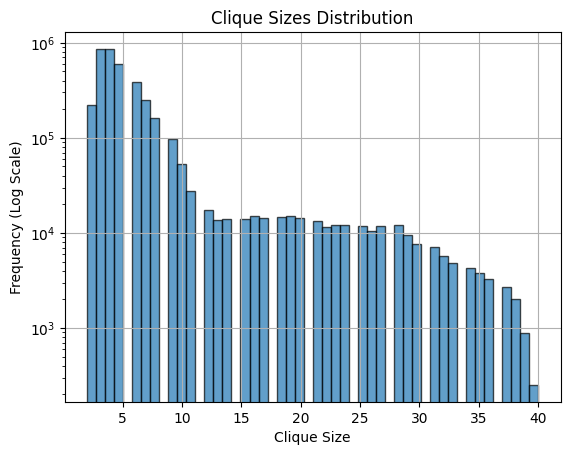

Hubs
Node 720575940626979621, Node Idx: 77033 Degree: 7795
Node 720575940628908548, Node Idx: 88047 Degree: 7515
Node 720575940625952755, Node Idx: 71713 Degree: 3612
Node 720575940627497244, Node Idx: 80246 Degree: 3484
Node 720575940628307026, Node Idx: 84745 Degree: 3291
Node 720575940620008758, Node Idx: 40090 Degree: 2939
Node 720575940634612194, Node Idx: 111920 Degree: 2899
Node 720575940613583001, Node Idx: 17263 Degree: 2884
Node 720575940624547622, Node Idx: 64794 Degree: 2860
Node 720575940629513222, Node Idx: 91062 Degree: 2813


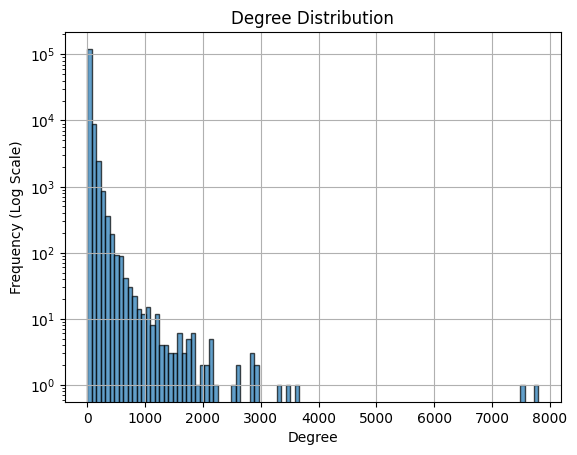

In [5]:
all_nodes = sorted(list(set(u for u, v in edges) | set(v for u, v in edges)))
node_to_idx = {node: i for i, node in enumerate(all_nodes)}
graph, adj_mat = get_graph(edges, all_nodes)
adj_graph = adj_mat

cliques = list(nx.find_cliques(graph))
sorted_cliques = sorted(cliques, key=len, reverse=True)
cc = nx.clustering(graph)
explore_cliques(sorted_cliques)
degree_distribution(graph, all_nodes)

In [ ]:
def find_closest_density(observed_density, lower_bound=True):
    """
    Find the density value that the observed density is greater than or equal to.
    """
    densities = [1/2**d for d in range(12)]
    if observed_density < densities[-1]:
        return densities[-1], 11, best_solution[-1]

    if lower_bound:
        closest_density = max(d for d in densities if d <= observed_density)
    else:
        closest_density = min(d for d in densities if d >= observed_density)
    return closest_density, densities.index(closest_density), best_solution[densities.index(closest_density)]

def filter_low_deg_nodes(graph, gamma, k):
    ### too strict condition: candidate node must have deg(v) > gamma * (K-1)
    degree_sequence = sorted(graph.degree(), key=lambda x: x[1], reverse=True)
    threshold = math.ceil(gamma * (k-1))
    print(f"Degree threshold: {threshold}")
    nodes = [node for node, degree in degree_sequence if degree >= threshold]
    print(f"remaining nodes: {len(nodes)} which is {len(nodes)/len(graph.nodes())*100:.2f}% of the original graph")
    return nodes

def prune_based_degree_quick(graph: nx.Graph, gamma=0.5, k=176):
    subset_nodes = filter_low_deg_nodes(graph, gamma=gamma, k=k)
    if len(subset_nodes) < k:
        return graph
    subset_graph = nx.induced_subgraph(graph, subset_nodes)
    d = calc_density(edges, set(all_nodes[i] for i in subset_nodes))
    print(d)
    print(find_closest_density(d, lower_bound=True))
    return subset_graph
    # return prune_based_degree(subset_graph, gamma=gamma, k=k)

def _solve_with_numpy(c):
    # Coefficients for k^2 - k - c = 0 are [1, -1, -c]
    # Where c = 2E / delta
    coefficients = [1, -1, -c]
    roots = np.roots(coefficients)
    return roots

def prune_based_degree(gamma=0.5):
    E = len(edges)
    solutions = _solve_with_numpy((2*E) / gamma)
    print(f"Solutions for k^2 - k - {2*E/gamma} = 0: {solutions}")
    max_k = int(np.max(np.abs(solutions)))
    print('the idx of the min indeg node:', max_k)

    degree_sequence = sorted(graph.degree(), key=lambda x: x[1], reverse=True)
    top_k_degrees = degree_sequence[0:max_k]
    top_k_nodes = [node for node, degree in top_k_degrees]
    return top_k_nodes

# old method - relevant to Quick algorithem which is more strict... no needed here i think 
# subgraph = prune_based_degree_quick(graph, gamma=0.5)

## Clustering

In [ ]:
# largest_cc = max(nx.connected_components(graph), key=len)
# # subgraph = graph.subgraph(largest_cc).copy()
# subgraph = nx.induced_subgraph(graph, largest_cc)
# print(f"CC Subgraph size: {len(subgraph)} nodes, {subgraph.number_of_edges()} edges")

In [ ]:
G = graph
nodes = list(G.nodes())
deg  = np.array([G.degree(n)             for n in nodes], dtype=float)
# cc   = np.array([nx.clustering(G, n)      for n in nodes], dtype=float)
# X = np.vstack([deg, cc]).T      # shape = (n_nodes, 2)

In [ ]:
desired_size = 1000
n_clusters   = max(1, len(nodes) // desired_size)
print(f"Number of clusters: {n_clusters}")

In [ ]:
A = nx.to_scipy_sparse_array(graph, format="csr", dtype=float)

A.indices = A.indices.astype(np.int32)
A.indptr  = A.indptr.astype(np.int32)

embed = SpectralEmbedding(
    n_components=16,
    affinity="precomputed",
    random_state=42,
    eigen_solver="lobpcg",       # faster for large sparse graphs !
)
Z = embed.fit_transform(A)

In [ ]:
# X_scaled = StandardScaler().fit_transform(X)
Z_scaled = StandardScaler().fit_transform(Z)
# XZ = np.hstack([X_scaled, Z_scaled])    # shape = (n, 2 + 16)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
# other features i tried ...
labels     = kmeans.fit_predict(StandardScaler().fit_transform(Z))
# labels     = kmeans.fit_predict(StandardScaler().fit_transform(X))
# labels     = kmeans.fit_predict(XZ)
node_to_cluster = dict(zip(nodes, labels))

In [ ]:
counts = collections.Counter(labels)
cluster_metrics = []
for clust_id, size in tqdm(sorted(counts.items())):
    if size < 100:
        continue
    # print(f"Cluster {clust_id:2d}: {size:3d} nodes")
    cluster_nodes = [i for i, c in enumerate(labels) if c == clust_id]
    density = calc_density_for_subgraph(graph, cluster_nodes)
    fitness = density * size
    cluster_metrics.append((clust_id, size, density, fitness))
    # print(f"Density: {density:.4f}")
    # print(find_closest_density(density, lower_bound=True))


In [ ]:
cluster_metrics.sort(key=lambda x: x[2], reverse=False)
print("Top clusters by fitness (cluster_id, size, density, fitness):")
for clust_id, size, dens, fit in cluster_metrics[:5]:
    print(f"  → #{clust_id:2d}: K={size:4d}, ρ={dens:.7f},  f={fit:.3f}")

In [ ]:
len(cluster_metrics)

In [ ]:
cluster_nodes = [i for i, c in enumerate(labels) if c == cluster_metrics[1][0]]

In [ ]:
len(cluster_nodes)

In [ ]:
densities

## Explore nx.approximation.densest_subgraph 

In [ ]:
# core = nx.approximation.densest_subgraph(G, iterations=3, method="greedy++")
# max_nx = core.number_of_edges() / core.number_of_nodes()
# print(f"Highest edges-per-node found: {max_nx:.2f}")

In [ ]:
d,s = nx.approximation.densest_subgraph(graph, iterations=1)

In [ ]:
print(len(s))
dens_s = calc_density_for_subgraph(graph, s)
print('actual density:', dens_s)
target_den = find_closest_density(dens_s, True)
print('target', target_den)

In [ ]:
quasi_clique6 = greedy_add_adj(nx.to_scipy_sparse_array(graph), s, target_density=0.015625)
print(calc_density_for_subgraph(graph, quasi_clique6))

## Greedy Basic Algo's
Appending nodes (iter based on degree) to the growing Q-clique group U;

Each iteration, find a node with max connections U

In [ ]:
def greedy_add_based_nx(graph: nx.Graph, initial_clique: list[int], target_density: float):
    """
    Starts with an initial clique (or quasi-clique) and greedily adds nodes to expand it into a quasi-clique
    until the target_density can no longer be met.
    """
    U = set(initial_clique)
    degree_sequence = sorted(graph.degree(), key=lambda x: x[1], reverse=True)
    candidate_nodes = [node for node, degree in degree_sequence if node not in U]

    iter_debug = 0
    while True:
        subgraph_U = graph.subgraph(U)
        num_edges_U = subgraph_U.number_of_edges()

        iter_debug += 1
        if iter_debug:
            density_U = calc_density(edges, set(all_nodes[i] for i in U))
            print(f"\tIter: {iter_debug}. Current quasi-clique size: {len(U)}, edges: {num_edges_U}, density: {density_U:.4f}")

        # Find the best candidate node to add
        best_candidate = None
        max_connections = -1
        for candidate_node in candidate_nodes:
            connections_to_U = sum(1 for neighbor in graph.neighbors(candidate_node) if neighbor in U)

            if connections_to_U > max_connections:
                max_connections = connections_to_U
                best_candidate = candidate_node

            if max_connections == (len(U) - 1):
                print(f"Candidate {best_candidate} connects to max nodes in U")
                break

        print(f"Best candidate: {best_candidate} with {max_connections} connections to U")

        # Calculate the density if we add the best candidate
        potential_num_nodes = len(U) + 1
        potential_num_edges = num_edges_U + max_connections
        max_possible_edges = potential_num_nodes * (potential_num_nodes - 1) / 2
        potential_density = potential_num_edges / max_possible_edges

        # If the new density is above the target, add the node and continue
        if potential_density >= target_density:
            U.add(best_candidate)
            num_edges_U = potential_num_edges
            candidate_nodes.remove(best_candidate)
        else:
            # If adding the best possible candidate violates the density, stop
            break

    return list(U)


def greedy_add_based_node_score_based_nx(graph: nx.Graph, initial_clique: list[int], target_density: float, cc: dict):
    """
    Starts with an initial clique (or quasi-clique) and greedily adds nodes to expand it into a quasi-clique
    until the target_density can no longer be met.
    """
    U = set(initial_clique)
    candidate_nodes = list(graph.nodes())
    # score of a node: 1/3 degree, 1/3 connections to U, 1/3 clustering coeff

    iter_debug = 0
    while True:
        subgraph_U = graph.subgraph(U)
        num_edges_U = subgraph_U.number_of_edges()

        iter_debug += 1
        if iter_debug:
            density_U = calc_density(edges, set(all_nodes[i] for i in U))
            print(f"\tIter: {iter_debug}. Current quasi-clique size: {len(U)}, edges: {num_edges_U}, density: {density_U:.4f}")

        # Find the best candidate node to add
        best_candidate = None
        max_score = 0
        max_connection_to_u = 0
        max_degree = 0
        max_cc = 0
        for candidate_node in candidate_nodes:
            connections_to_U = sum(1 for neighbor in graph.neighbors(candidate_node) if neighbor in U)
            node_degree = graph.degree(candidate_node)
            node_cc = cc[candidate_node]

            node_score = (0.5) * (connections_to_U / (len(U) - 1) if len(U) > 1 else 0) + (0.25) * (node_degree / (len(graph.nodes()) - 1)) + (0.25) * node_cc

            if node_score > max_score:
                max_score = node_score
                best_candidate = candidate_node
                max_connection_to_u = connections_to_U
                max_degree = node_degree
                max_cc = node_cc

        print(f"Best candidate: {best_candidate} with score: {max_score:.4f}, {max_connection_to_u} connections to U, {max_degree} degree, {max_cc:.4f} clustering coeff")

        # Calculate the density if we add the best candidate
        potential_num_nodes = len(U) + 1
        potential_num_edges = num_edges_U + max_connection_to_u
        max_possible_edges = potential_num_nodes * (potential_num_nodes - 1) / 2
        potential_density = potential_num_edges / max_possible_edges

        # If the new density is above the target, add the node and continue
        if potential_density >= target_density:
            U.add(best_candidate)
            num_edges_U = potential_num_edges
            candidate_nodes.remove(best_candidate)
        else:
            # If adding the best possible candidate violates the density, stop
            break

    return list(U)


def greedy_swap_based_nx(graph: nx.Graph, group: list[int]):
    U_ = set(group)
    while True:
        subgraph = nx.induced_subgraph(graph, U_)
        sub_degrees = [val for (node, val) in subgraph.degree()]
        sub_nodes = [node for (node, val) in subgraph.degree()]

        min_degree_in_u = min(sub_degrees)
        min_node_idx = sub_degrees.index(min_degree_in_u)
        min_node = sub_nodes[min_node_idx]
        print(f"Min degree: {min_degree_in_u}, node: {min_node}")

        candidate_nodes = [node for node in graph.nodes() if node not in U_]
        conn_to_u = [sum(1 for neighbor in graph.neighbors(cn) if neighbor in U_) for cn in candidate_nodes]
        max_degree = max(conn_to_u)

        # choose the node with highest degree
        max_nodes_indices = np.where(np.array(conn_to_u) == max_degree)[0]
        max_nodes = np.array(candidate_nodes)[max_nodes_indices]
        max_nodes_full_degree = [graph.degree(node) for node in max_nodes]
        max_node = max_nodes[np.argmax(max_nodes_full_degree)]
        print(f"Max degree: {max_degree}, node: {max_node}")

        # Swap:
        if min_degree_in_u < max_degree:
            density_before = calc_density_for_subgraph(graph, U_)
            print(f"Current density: {density_before}")

            U_.remove(min_node)
            U_.add(max_node)

            density_after = calc_density_for_subgraph(graph, U_)
            print(f"New density: {density_after}")
            if density_after == density_before:
                print(f"Swapped {min_degree_in_u} with {max_degree}, but density is the same.")
                print("Density is the same after swap, no changes made.")
                break
        else:
            print(f"max = min degree {min_degree_in_u}")
            break
    return U_


def greedy_swap_adj(adj, group):
    """
    Greedy swap using an adjacency matrix (dense or SciPy sparse).
    Logic mirrors your networkx version:
      - Find node in U with min internal degree.
      - Find outside node with max connections to U.
      - If max_conn > min_deg: swap them.
      - Print current/new densities; if density didn't change after the swap, break.
      - Stop if max_conn <= min_deg.
    """
    N = adj.shape[0]
    U_list = np.array(list(dict.fromkeys(group)), dtype=int)  # dedup while preserving order

    # --- Helpers ---
    def density_from_edges(m_edges, k):
        return 0.0 if k < 2 else (2.0 * m_edges) / (k * (k - 1))

    # 1) Initial #edges in U
    if U_list.size == 0:
        return U_list.tolist()

    if issparse(adj):
        num_edges_U = adj[U_list][:, U_list].nnz // 2
        degrees = np.asarray(adj.sum(axis=1)).ravel()
    else:
        num_edges_U = int(adj[np.ix_(U_list, U_list)].sum() // 2)
        degrees = adj.sum(axis=1)

    # 2) Degree order once, and initial candidates (outside U)
    degree_order = np.argsort(degrees)[::-1]
    in_U_mask = np.zeros(N, dtype=bool)
    in_U_mask[U_list] = True
    candidates = degree_order[~in_U_mask[degree_order]]

    # 3) Membership mask for vector ops
    mask_U = np.zeros(N, dtype=int)
    mask_U[U_list] = 1

    iter_no = 0
    while True:
        iter_no += 1
        k = U_list.size
        density_before = density_from_edges(num_edges_U, k)
        if iter_no % 1000 == 0:
            print(f"Swap-Iter {iter_no}: |U|={k}, edges={num_edges_U}, density={density_before:.4f}")

        if candidates.size == 0:
            break

        # Internal degrees of nodes in U (vectorized)
        degU = adj[U_list].dot(mask_U)
        if issparse(adj):
            degU = np.asarray(degU).ravel()

        min_idx = int(np.argmin(degU))
        min_node = int(U_list[min_idx])
        min_deg = int(degU[min_idx])

        # Outside connections to U (vectorized)
        conn = adj[candidates].dot(mask_U)
        if issparse(adj):
            conn = np.asarray(conn).ravel()

        best_idx = int(np.argmax(conn))
        best_node = int(candidates[best_idx])
        best_conn = int(conn[best_idx])

        # best_conn = conn.max()
        ties = np.flatnonzero(conn == best_conn)
        if ties.size > 1:
            tie_nodes = candidates[ties]
            tie_degs  = degrees[tie_nodes]  # precomputed once
            # lexsort: primary = -degree (higher first), secondary = node id (smaller first)
            order = np.lexsort((tie_nodes, -tie_degs))
            best_idx = int(ties[order[0]])
        else:
            best_idx = int(ties[0])
        best_node = int(candidates[best_idx])

        # Style like greedy_add_adj
        # print(f"  worst-in-U {min_node} with deg {min_deg}")
        # print(f"  best candidate {best_node} with {best_conn} links to U")

        # Stop if swap can't help
        if min_deg >= best_conn:
            print(f"max = min degree {min_deg}")
            break

        # print(f"Current density: {density_before}")

        # Compute how many of best_node's links to U survive after removing min_node
        if issparse(adj):
            edge_bw = int(adj[best_node, min_node] != 0)
        else:
            edge_bw = int(adj[best_node, min_node] != 0)
        conn_without_min = best_conn - edge_bw

        # Update edges count for the swapped set (|U| unchanged)
        m_after = num_edges_U - min_deg + conn_without_min
        density_after = density_from_edges(m_after, k)
        # print(f"New density: {density_after}")

        # --- Apply the swap ---
        # Update mask and U_list in-place (replace min_node with best_node)
        mask_U[min_node] = 0
        mask_U[best_node] = 1
        U_list[min_idx] = best_node
        num_edges_U = m_after

        # Keep candidates vector the same length: the swapped-out node becomes a candidate
        candidates[best_idx] = min_node

        # If density didn't change, stop (matches your original behavior)
        if density_after == density_before:
            print(f"Swapped {min_deg} with {best_conn}, but density is the same.")
            print("Density is the same after swap, no changes made.")
            break

    return U_list.tolist()


#my first attempt using the greedy, for all 12 gammas

# densities = [1/2**d for d in range(12)]
# curr_q_clique = sorted_cliques[0]
# quasi_cliques = [curr_q_clique]
# for d in densities[1:]:
#     print(f"---Target density: {d}")
#     quasi_clique = greedy_add_based_nx(graph, curr_q_clique, target_density=d)

#     density = calc_density(edges, set(all_nodes[i] for i in quasi_clique))
#     print(f"---Found quasi-clique of size {len(quasi_clique)} density: {density:.4f}")

#     quasi_cliques.append(quasi_clique)
#     curr_q_clique = quasi_clique

# save_output_csv(quasi_cliques, output_path="res_greedy_degree12.csv")


def greedy_add_adj(adj, initial_clique, target_density):
    N = adj.shape[0]
    U = set(initial_clique)
    U_list = np.fromiter(U, dtype=int)

    # 1) Compute initial edge‐count in U
    if issparse(adj):
        num_edges_U = adj[U_list][:, U_list].nnz // 2
    else:
        num_edges_U = int(adj[np.ix_(U_list, U_list)].sum() // 2)

    # 2) Precompute degree ordering once
    if issparse(adj):
        degrees = np.asarray(adj.sum(axis=1)).ravel()
    else:
        degrees = adj.sum(axis=1)
    degree_order = np.argsort(degrees)[::-1]
    candidates = degree_order[~np.isin(degree_order, U_list)]

    # 3) Build a 0/1 mask vector for membership in U
    mask_U = np.zeros(N, dtype=int)
    mask_U[U_list] = 1

    iter_no = 0
    while True:
        iter_no += 1
        size_U = len(U)

        if iter_no % 1000 == 0:
            density_U = (2 * num_edges_U) / (size_U * (size_U - 1)) if size_U > 1 else 0.0
            print(f"Add-Iter {iter_no}: |U|={size_U}, edges={num_edges_U}, density={density_U:.4f}")

        if candidates.size == 0:
            break

        # 4) Vectorised “connections to U” for all candidates
        conn = adj[candidates].dot(mask_U)
        if issparse(adj):
            conn = np.asarray(conn).ravel()

        best_idx = int(np.argmax(conn))
        best_node = int(candidates[best_idx])
        best_conn = int(conn[best_idx])
        # print(f"  best candidate {best_node} with {best_conn} links to U")

        # 5) Density check if we add that node
        pot_nodes = size_U + 1
        pot_edges = num_edges_U + best_conn
        pot_density = (2 * pot_edges) / (pot_nodes * (pot_nodes - 1))

        if pot_density >= target_density: # accept it
            U.add(best_node)
            num_edges_U = pot_edges
            mask_U[best_node] = 1
            candidates = np.delete(candidates, best_idx)
        else:
            break

    return list(U)


def greedy_remove_adj(adj, group, target_density):
    N = adj.shape[0]
    node_list = list(range(N))

    # Current set G (by adjacency‐indices) and a mask for fast sums
    G = set(group)
    mask = np.zeros(N, dtype=int)
    mask[list(G)] = 1

    # Count initial edges inside G
    G_idx = np.fromiter(G, dtype=int)
    if issparse(adj):
        num_edges = adj[G_idx][:, G_idx].nnz // 2
    else:
        num_edges = int(adj[np.ix_(G_idx, G_idx)].sum() // 2)

    # Candidates = current members (we’ll remove from here)
    candidates = G_idx.copy()
    iter_no = 0

    while True:
        size_G = mask.sum()
        density = (2 * num_edges) / (size_G * (size_G - 1)) if size_G > 1 else 0.0
        iter_no += 1
        if iter_no % 100 == 0:
            print(f"Remove-Iter {iter_no}: |G|={size_G}, edges={num_edges}, density={density:.4f}")

        # Stop once we hit the target density or have no one left to remove
        if density >= target_density or candidates.size == 0:
            break

        # Compute each candidate’s internal links via one matrix–vector multiply
        links = adj[candidates].dot(mask)
        if issparse(adj):
            links = np.asarray(links).ravel()

        # Remove the node with the fewest links (max density gain)
        rm_idx = int(np.argmin(links))
        node_rm = int(candidates[rm_idx])
        link_rm = int(links[rm_idx])
        # print(f"  removing {node_list[node_rm]} (idx={node_rm}) with {link_rm} internal links")

        # Update edge count & mask
        num_edges -= link_rm
        mask[node_rm] = 0
        candidates = np.delete(candidates, rm_idx)

    # Now map back to labels
    kept_idx = np.flatnonzero(mask)
    return [node_list[i] for i in kept_idx]

In [ ]:
def _to_cc_array(cc, n):
    """Accepts a dict or array-like and returns a length-n float64 array."""
    if isinstance(cc, dict):
        # assumes keys are 0..n-1 (use nx wrapper below if your nodes aren't 0..n-1)
        arr = np.zeros(n, dtype=np.float64)
        for k, v in cc.items():
            arr[int(k)] = float(v)
        return arr
    arr = np.asarray(cc, dtype=np.float64)
    if arr.shape[0] != n:
        raise ValueError("cc length does not match number of nodes")
    return arr

def _nnz_upper_tri(adj, idx):
    """Compute #edges inside idx for an undirected 0/1 adjacency."""
    s = len(idx)
    if s <= 1:
        return 0
    if issparse(adj):
        # count nonzeros in the induced submatrix and divide by 2
        sub = adj[idx][:, idx]
        return int(sub.nnz // 2)
    else:
        block = adj[np.ix_(idx, idx)]
        # block is symmetric 0/1; sum counts each edge twice
        return int(block.sum() // 2)

def greedy_add_based_node_score_adj(
    adj,
    initial_group,
    target_density,
    cc,
    degrees=None,
    debug=True,
):
    """
    Vectorized greedy-add using your node score:
      score = 0.5 * (conn_to_U / (|U|-1)) + 0.25 * (deg / (n-1)) + 0.25 * cc

    Parameters
    ----------
    adj : (N,N) ndarray or csr_matrix
        Undirected, 0/1 adjacency (diagonal assumed zero).
    initial_group : list[int]
        Seed nodes (indices 0..N-1).
    target_density : float
        Density threshold; stop when adding the best candidate would drop below it.
    cc : dict or array-like of length N
        Clustering coefficient per node (0..1).
    degrees : array-like of length N, optional
        If provided, used directly; otherwise computed from adj.
    debug : bool
        Print progress each iteration.

    Returns
    -------
    list[int]
        Final set U.
    """
    # Coerce to CSR for efficient column extraction (if sparse)
    if issparse(adj) and not isinstance(adj, csr_matrix):
        adj = adj.tocsr()

    n = adj.shape[0]
    U_mask = np.zeros(n, dtype=bool)
    U_mask[np.asarray(initial_group, dtype=int)] = True

    cc_arr = _to_cc_array(cc, n)

    # Degrees & degree normalization
    if degrees is None:
        if issparse(adj):
            degrees = np.asarray(adj.sum(axis=1)).ravel()
        else:
            degrees = adj.sum(axis=1)
    else:
        degrees = np.asarray(degrees)
    deg_norm = degrees.astype(np.float64) / max(1, (n - 1))

    # Initial edge count inside U
    U_idx = np.flatnonzero(U_mask)
    num_edges_U = _nnz_upper_tri(adj, U_idx)

    # Vector of connections to U for every node (including nodes in U)
    if U_idx.size == 0:
        conn_to_U = np.zeros(n, dtype=np.int64)
    elif U_idx.size == 1:
        if issparse(adj):
            conn_to_U = adj.getcol(U_idx[0]).toarray().ravel().astype(np.int64)
        else:
            conn_to_U = adj[:, U_idx[0]].astype(np.int64)
    else:
        if issparse(adj):
            conn_to_U = adj[:, U_idx].sum(axis=1).A1.astype(np.int64)
        else:
            conn_to_U = adj[:, U_idx].sum(axis=1).astype(np.int64)

    iter_no = 0
    while True:
        iter_no += 1
        s = int(U_mask.sum())

        # Current density in U
        if s >= 2:
            density_U = (2.0 * num_edges_U) / (s * (s - 1))
        else:
            density_U = 0.0

        if debug:
            print(f"\tIter: {iter_no}. Current quasi-clique size: {s}, edges: {num_edges_U}, density: {density_U:.4f}")

        # Compute score vector for all nodes, mask out U
        if s > 1:
            conn_term = conn_to_U.astype(np.float64) / (s - 1)
        else:
            conn_term = np.zeros(n, dtype=np.float64)

        scores = 0.4 * conn_term + 0.2 * deg_norm + 0.4 * cc_arr
        scores[U_mask] = -np.inf  # exclude nodes already in U

        # If no candidates remain, stop
        best = int(np.argmax(scores))
        best_score = scores[best]
        if np.isneginf(best_score):
            break

        # Debug info for the best candidate
        best_conn = int(conn_to_U[best])
        best_deg = int(degrees[best])
        best_cc = float(cc_arr[best])
        if debug:
            print(
                f"Best candidate: {best} with score: {best_score:.4f}, "
                f"{best_conn} connections to U, {best_deg} degree, {best_cc:.4f} clustering coeff"
            )

        # Potential density if we add 'best'
        s_new = s + 1
        num_edges_new = num_edges_U + best_conn
        max_possible_edges = s_new * (s_new - 1) / 2.0
        potential_density = num_edges_new / max_possible_edges

        if potential_density >= target_density:
            # Accept: update U, edge count, and incrementally update conn_to_U
            U_mask[best] = True
            num_edges_U = num_edges_new

            # Incremental update: each node's conn_to_U increases by adj[i, best]
            if issparse(adj):
                inc = adj.getcol(best).toarray().ravel()
            else:
                inc = adj[:, best]
            # Ensure dtype alignment (avoid int16/float64 casting issues)
            conn_to_U = conn_to_U + inc.astype(np.int64)
        else:
            # Best candidate would violate target density -> stop
            break

    return list(np.flatnonzero(U_mask))

### Greedy new Approch;
for each gamma
1. start with a clique, as before, expand it to quasi_clique (QC) in a greedy fashion as before
2. swap method: swap the lowest deg nodes in the induced QC with better ones from the entire graph 
2.1 this stops when we cant find a switch that improves the density
2.2 size of QC |V| remains the same, but its density improves, i.e, increases (we choose nodes with more edges conenct to QC)
3. back to step 1: expand it as much as possible (|V| goes up, density goes down untill reached target)
4. reapet

In [ ]:
def swap_greedy_loop(qc_sol, target_density):
    while True:
        qc_sol_new = greedy_swap_adj(adj_graph, qc_sol)
        if calc_density_for_subgraph(graph, qc_sol) == calc_density_for_subgraph(graph, qc_sol_new):
            print("Density is the same after swap, no changes made.")
            break
        print(f"Swapped to new solution of size {len(qc_sol_new)}, start adding")

        qc_sol = greedy_add_based_node_score_adj(adj_graph, list(qc_sol_new), target_density=target_density, cc=cc, debug=False)
        qc_sol = greedy_add_adj(adj_graph, qc_sol, target_density=target_density)
    return qc_sol


def swap_greedy_loop_with_add_k(qc_sol, target_density):
    while True:
        qc_sol_new = greedy_swap_adj(adj_graph, qc_sol)
        if calc_density_for_subgraph(graph, qc_sol) == calc_density_for_subgraph(graph, qc_sol_new):
            print("Density is the same after swap, no changes made.")
            break
        print(f"Swapped to new solution of size {len(qc_sol_new)}, start adding")
        qc_sol = greedy_add_k_based_adj_r(adj_graph, initial_group=qc_sol_new, target_density=target_density, sorted_cliques=sorted_cliques, sample_size=0.005)
        qc_sol = greedy_add_adj(adj_graph, qc_sol, target_density=target_density)
    return qc_sol


def mixed_swap_greedy_loop(qc_sol, target_density):
    inner_loop_count = 0
    while True:
        inner_loop_count += 1
        qc_sol_new = greedy_swap_adj(adj_graph, qc_sol)
        if calc_density_for_subgraph(graph, qc_sol) == calc_density_for_subgraph(graph, qc_sol_new):
            print("Density is the same after swap, no changes made.")
            break
        print(f"Swapped to new solution of size {len(qc_sol_new)}, start adding")
        if inner_loop_count % 2 == 0:
            qc_sol = greedy_add_k_based_adj_r(adj_graph, initial_group=qc_sol_new, target_density=target_density, sorted_cliques=sorted_cliques, sample_size=0.005)
        else:
            qc_sol = greedy_add_based_node_score_adj(adj_graph, list(qc_sol_new), target_density=target_density, cc=cc, debug=False)
        qc_sol = greedy_add_adj(adj_graph, qc_sol, target_density=target_density)
    return qc_sol


### Add random to the process
1. remove x% random nodes
2. do a greedy swap-add iteration


In [ ]:
rand_new_sols = {}

In [ ]:
d_idx = 5
dens_ = densities[d_idx]

qc_sol = my_sol[d_idx]
qc_sol = [node_to_idx[node] for node in qc_sol]

print(f"start solution size: {len(qc_sol)} and density: {calc_density_for_subgraph(graph, qc_sol)}")

In [ ]:
print({d: len(rand_new_sols[d]) for d in rand_new_sols})

In [ ]:
import random
np.random.seed(42)

def randomize_nodes_remove(qc_sol, rand_ratio=0.1):
    sample_size = int(len(qc_sol) * rand_ratio)
    remove_ = random.sample(qc_sol, sample_size)
    qc_sol_randomized = set(qc_sol) - set(remove_)
    return qc_sol_randomized

iter_per_d = 25

for d_idx in list(range(8,12)):
    dens_ = densities[d_idx]

    qc_sol = my_sol[d_idx]
    qc_sol = [node_to_idx[node] for node in qc_sol]

    print(f"start solution size: {len(qc_sol)} and density: {calc_density_for_subgraph(graph, qc_sol)}")

    for i in [random.uniform(0.25, 0.55) for _ in range(iter_per_d)]:
        print('-------------------------------- RAND RATIO ITER', i)
        qc_sol_randomized = randomize_nodes_remove(qc_sol, rand_ratio=i)
        print(f"Randomized solution size: {len(qc_sol_randomized)} and density: {calc_density_for_subgraph(graph, qc_sol_randomized)}")
        qc_sol_new = mixed_swap_greedy_loop(qc_sol_randomized, dens_)
        # qc_sol_new = swap_greedy_loop_with_add_k(qc_sol_randomized, target_density=dens_, adj_graph=adj_graph)
        print(f"solution size: {len(qc_sol_new)} and density: {calc_density_for_subgraph(graph, qc_sol_new)}")

        if len(qc_sol_new) > len(rand_new_sols.get(dens_, [])):
            rand_new_sols[dens_] = qc_sol_new

print({d: len(rand_new_sols[d]) for d in rand_new_sols})

### single improvemnt using larger or smaller QC

In [ ]:
def go_down_():
    new_sol_qc = {}
    new_sol_lens = {}
    for prev_qc_sol, d in zip(my_sol, densities):
        qc_sol = [node_to_idx[node] for node in prev_qc_sol]
        if d >=0.25:
            new_sol_qc[d] = qc_sol
            new_sol_lens[d] = len(qc_sol)
        else:
            pass
            print('Start ---------------------', len(prev_qc_sol), d)
            qc_sol_new = swap_greedy_loop(qc_sol, target_density=d)
            print('Ends ----------------------', len(qc_sol_new), d)

            new_sol_lens[d] = len(qc_sol_new)
            new_sol_qc[d] = qc_sol_new
    return new_sol_qc, new_sol_lens


def go_up_():
    new_sol_qc = {}
    new_sol_lens = {}

    for d in densities[1:5]:
        prev_qc_sol = my_sol_data[d]
        print('\nStart ---------------------', len(prev_qc_sol), d)

        upper_sol = my_sol_data[d/8]
        # upper_sol = my_sol_data[densities[-1]] # doesnt improve
        qc_upper_sol = [node_to_idx[node] for node in upper_sol]
        qc_sol_new = greedy_remove_adj(adj_graph, qc_upper_sol, target_density=d)
        print('Ends remove ----------------------', len(qc_sol_new))
        qc_sol_new = swap_greedy_loop(qc_sol_new, target_density=d)
        print('Ends swap ----------------------', len(qc_sol_new))
        new_sol_lens[d] = len(qc_sol_new)
        new_sol_qc[d] = qc_sol_new
    return new_sol_qc, new_sol_lens
# up_sol_qc, up_sol_lens = go_up_()
# down_sol_qc, down_sol_lens = go_down_()

In [ ]:
# merge best solution
max_sol = {}
for d in my_sol_lens:
    if d not in rand_new_sols:
        sol_obj = my_sol_data[d]
        sol_obj = [node_to_idx[node] for node in sol_obj]
    else:
        sol_obj = rand_new_sols[d]
    max_sol[d] = sol_obj

max_sol_lens = {d: len(max_sol[d]) for d in max_sol}
max_sol_lens

### Greedy Add k 

In [ ]:
def greedy_add_k_based_nx(graph: nx.Graph, initial_group: list[int], target_density: float, sorted_cliques:list[int], k=40, sample_size=0.005):
    """
    Starts with an initial clique (or quasi-clique) and greedily adds up to k nodes to expand it into a quasi-clique
    until the target_density can no longer be met.
    """
    small_cliques = [clique for clique in sorted_cliques if len(clique) <= k]
    print(len(small_cliques), "small cliques found (size <= k)")
    U = set(initial_group)
    print('batch size: ', int(len(small_cliques) * sample_size))

    iter_no = 0
    while True:
        sample_small_cliques = random.sample(small_cliques, int(len(small_cliques) * sample_size))

        iter_no += 1
        if True or iter_no % 1000 == 0:
            num_edges_U = graph.subgraph(U).number_of_edges()
            size_U = len(U)
            density_U = (2 * num_edges_U) / (size_U * (size_U - 1)) if size_U > 1 else 0.0
            print(f"Add-K-Iter {iter_no}: |U|={size_U}, edges={num_edges_U}, density={density_U:.4f}")

        # rank small cliques by their connections to U
        s_clique_ranks = []
        for s_clique in sample_small_cliques:
            if not U.isdisjoint(s_clique):
                continue
            s_clique_connections = (sum([1 for node in s_clique for neighbor in graph.neighbors(node) if neighbor in U]) / len(s_clique)) # average connections to U
            s_clique_ranks.append((s_clique_connections, s_clique))

        if not s_clique_ranks:
            print('cant find any small clique to add')
            break

        s_clique_ranks.sort(reverse=True, key=lambda x: x[0])
        best_s_clique_conn, best_s_clique = s_clique_ranks[0]
        # print(f"Best small clique: {best_s_clique} with avg connections {best_s_clique_conn}")

        # Check if adding this clique maintains the density
        potential_U = U.union(set(best_s_clique))
        if calc_density_for_subgraph(graph, potential_U) >= target_density:
            U = potential_U
        else:
            print('best clique is over target density')
            # If the best clique is crossing the density threshold, we're done
            break

    return list(U)

from typing import List
import random

def greedy_add_k_based_adj(
    graph: nx.Graph,
    initial_group: List[int],
    target_density: float,
    sorted_cliques: List[List[int]],
    k: int = 40,
    sample_size: float = 0.005,
    rng: random.Random | None = None,
) -> List[int]:
    if rng is None:
        rng = random

    # --- compact indexing ---
    nodes = list(graph.nodes())
    idx_of = {u: i for i, u in enumerate(nodes)}
    N = len(nodes)

    # --- neighbor arrays (no SciPy): nbrs[i] is np.array of neighbor indices of node i ---
    # building once is O(E) but purely Python->NumPy; afterwards updates are cheap
    nbrs = [None] * N
    adj = graph.adj  # networkx adjacency
    for u, i in idx_of.items():
        # store as int32 for compactness
        nbrs[i] = np.fromiter((idx_of[v] for v in adj[u].keys()), dtype=np.int32)

    # --- U as mask ---
    U_mask = np.zeros(N, dtype=bool)
    if initial_group:
        U_idx = np.fromiter((idx_of[u] for u in initial_group), dtype=np.int32)
        U_mask[U_idx] = True
    else:
        U_idx = np.empty(0, dtype=np.int32)

    # --- count edges(U) quickly using neighbor arrays ---
    if U_idx.size <= 1:
        edges_U = 0
    else:
        # sum over u in U of neighbors within U, then //2 (undirected)
        s = 0
        for ui in U_idx:
            s += int(U_mask[nbrs[int(ui)]].sum())
        edges_U = s // 2

    # --- collect small cliques as index arrays ---
    small = [c for c in sorted_cliques if len(c) <= k]
    print(len(small), "small cliques found (size <= k)")
    if not small:
        return list(initial_group)

    small_idx = [np.fromiter((idx_of[u] for u in c), dtype=np.int32) for c in small]
    sizes = np.array([len(c) for c in small_idx], dtype=np.int32)
    inside_edges = (sizes * (sizes - 1)) // 2  # since they are true cliques

    batch = max(1, int(len(small_idx) * sample_size))
    print('batch size: ', batch)

    # --- inverted index node -> cliques for fast blocking ---
    M = len(small_idx)
    cliques_of_node = [[] for _ in range(N)]
    for ci, C in enumerate(small_idx):
        for v in C:
            cliques_of_node[int(v)].append(ci)
    cliques_of_node = [np.array(lst, dtype=np.int32) if lst else np.empty(0, dtype=np.int32)
                       for lst in cliques_of_node]

    blocked = np.zeros(M, dtype=bool)
    if U_idx.size:
        touched = np.unique(np.concatenate([cliques_of_node[int(v)] for v in U_idx if cliques_of_node[int(v)].size]))
        blocked[touched] = True
    eligible = np.flatnonzero(~blocked)

    # --- running dU[v] = |N(v) ∩ U| ---
    dU = np.zeros(N, dtype=np.int32)
    if U_idx.size:
        # vectorized: for each u in U, increment its neighbors by 1
        for ui in U_idx:
            nb = nbrs[int(ui)]
            if nb.size:
                dU[nb] += 1

    iter_no = 0
    while True:
        iter_no += 1
        size_U = int(U_mask.sum())
        if iter_no % 1000 == 0:
            density_U = (2 * edges_U) / (size_U * (size_U - 1)) if size_U > 1 else 0.0
            print(f"Add-K-Iter {iter_no}: |U|={size_U}, edges={edges_U}, density={density_U:.4f}")

        if eligible.size == 0:
            print('cant find any small clique to add')
            break

        # sample eligible cliques (without replacement)
        if eligible.size <= batch:
            sample_idx = eligible
        else:
            sample_idx = np.array(rng.sample(list(eligible), batch), dtype=np.int32)

        # rank by avg connections to U: mean(dU[C])
        best_ci = -1
        best_mean = -1.0
        best_sum = 0
        for ci in sample_idx:
            C = small_idx[int(ci)]
            # skip if intersects U (shouldn't happen if blocked/eligible are correct, but keep cheap guard)
            if U_mask[C].any():
                continue
            s = int(dU[C].sum())
            m = s / C.size
            if m > best_mean:
                best_mean = m
                best_sum = s
                best_ci = int(ci)

        if best_ci == -1:
            print('cant find any small clique to add')
            break

        Cbest = small_idx[best_ci]
        # best_nodes = [nodes[i] for i in Cbest]
        # print(f"Best small clique: {best_nodes} with avg connections {best_mean:.3f}")

        # predict density after adding Cbest
        c_size = Cbest.size
        new_size = size_U + c_size
        new_edges = edges_U + best_sum + int(inside_edges[best_ci])
        new_density = (2 * new_edges) / (new_size * (new_size - 1)) if new_size > 1 else 0.0

        if new_density >= target_density:
            # commit
            U_mask[Cbest] = True
            edges_U = new_edges

            # update dU by adding neighbors of every node in Cbest
            for w in Cbest:
                nb = nbrs[int(w)]
                if nb.size:
                    dU[nb] += 1

            # block cliques that now intersect U (only those touching Cbest)
            touched = np.unique(np.concatenate([cliques_of_node[int(v)] for v in Cbest
                                                if cliques_of_node[int(v)].size]))
            blocked[touched] = True
            eligible = eligible[~blocked[eligible]]
        else:
            print('best clique is over target density')
            break

    return [nodes[i] for i in np.flatnonzero(U_mask)]


def greedy_add_k_based_adj_r(
    adj,
    initial_group,
    target_density: float,
    sorted_cliques,
    k: int = 40,
    sample_size: float = 0.005,
    assume_cliques: bool = True,
    random_state: int | None = None,
    verbose: bool = True,
):
    """
    Greedy add groups (|C|<=k) maximizing avg connections to U each iteration.
    Sampling happens *inside* the loop from the current eligible pool.
    """
    DTYPE = np.int64  # keep integer math consistent

    # Normalize adjacency
    if issparse(adj) and not isinstance(adj, csr_matrix):
        adj = adj.tocsr()
    N = adj.shape[0]
    rng = np.random.default_rng(random_state)

    # Keep only small cliques
    small_cliques = [np.asarray(c, dtype=int) for c in sorted_cliques if len(c) <= k]
    M = len(small_cliques)
    if verbose:
        print(f"{M} small cliques found (size <= {k})")
        print("initial batch hint:", max(1, int(M * sample_size)))

    # Node -> cliques index for fast blocking updates
    node_to_cliques = [[] for _ in range(N)]
    for ci, C in enumerate(small_cliques):
        for v in C:
            node_to_cliques[v].append(ci)

    # U mask
    U_mask = np.zeros(N, dtype=bool)
    if len(initial_group):
        U_mask[np.asarray(initial_group, dtype=int)] = True

    # Initial edges(U)
    U_idx = np.flatnonzero(U_mask)
    if U_idx.size <= 1:
        num_edges_U = 0
    else:
        num_edges_U = (adj[U_idx][:, U_idx].nnz // 2) if issparse(adj) \
                      else int(adj[np.ix_(U_idx, U_idx)].sum() // 2)

    # conn_to_U[j] = #neighbors of j currently in U
    if U_idx.size:
        U_int = U_mask.astype(np.int8)
        conn_to_U = adj.dot(U_int) if issparse(adj) else adj.dot(U_int)
        conn_to_U = np.asarray(conn_to_U, dtype=DTYPE).ravel()
    else:
        conn_to_U = np.zeros(N, dtype=DTYPE)

    # Block cliques intersecting initial U
    is_blocked = np.zeros(M, dtype=bool)
    if U_idx.size:
        for v in U_idx:
            for ci in node_to_cliques[v]:
                is_blocked[ci] = True

    iter_no = 0
    while True:
        iter_no += 1
        size_U = int(U_mask.sum())
        density_U = (2 * num_edges_U) / (size_U * (size_U - 1)) if size_U > 1 else 0.0
        if verbose and iter_no % 1000 == 0:
            print(f"Add-K-Iter {iter_no}: |U|={size_U}, edges={num_edges_U}, density={density_U:.4f}")

        # ---- sample FROM CURRENT ELIGIBLE pool ----
        eligible_idx = np.flatnonzero(~is_blocked)
        if eligible_idx.size == 0:
            if verbose: print("cant find any small clique to add")
            break

        batch = max(1, int(eligible_idx.size * sample_size))
        if eligible_idx.size > batch:
            candidates = rng.choice(eligible_idx, size=batch, replace=False)
        else:
            candidates = eligible_idx  # take all if small
        # -------------------------------------------

        # Rank by AVG connections to U: (sum(conn_to_U[C]) / |C|)
        best_idx, best_avg, best_conn_total = None, -1.0, 0
        for ci in candidates:
            C = small_cliques[ci]
            s = C.size
            if s == 0:
                continue
            conn_CU = int(conn_to_U[C].sum())
            avg_conn = conn_CU / s
            if avg_conn > best_avg:
                best_avg = avg_conn
                best_idx = ci
                best_conn_total = conn_CU

        if best_idx is None:
            if verbose: print("cant find any small clique to add")
            break

        C_best = small_cliques[best_idx]
        s = C_best.size

        # Internal edges for C_best
        if assume_cliques:
            edges_inside_C = s * (s - 1) // 2
        else:
            edges_inside_C = (adj[C_best][:, C_best].nnz // 2) if issparse(adj) \
                             else int(adj[np.ix_(C_best, C_best)].sum() // 2)

        conn_CU = best_conn_total
        new_size  = size_U + s
        new_edges = num_edges_U + edges_inside_C + conn_CU
        new_density = (2 * new_edges) / (new_size * (new_size - 1)) if new_size > 1 else 0.0

        # if verbose:
            # print(f"Best small clique: {C_best.tolist()} with avg connections {best_avg:.4f}")

        if new_density >= target_density:
            # Commit add
            U_mask[C_best] = True
            num_edges_U = new_edges

            # Incrementally update conn_to_U by adding neighbors of C_best
            if issparse(adj):
                inc = np.asarray(adj[C_best].sum(axis=0), dtype=DTYPE).ravel()
            else:
                inc = np.asarray(adj[C_best].sum(axis=0), dtype=DTYPE).ravel()
            conn_to_U += inc

            # Block all cliques that now intersect U
            for v in C_best:
                for ci in node_to_cliques[v]:
                    is_blocked[ci] = True
        else:
            if verbose: print("best clique is over target density")
            break

    return np.flatnonzero(U_mask).tolist()